In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import SpectralClustering, SpectralBiclustering, SpectralCoclustering
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import umap
#from hdbscan import HDBSCAN
from sklearn.cluster import HDBSCAN
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "..")   
from src.gdkm import compute_gdkm_cv_scores, suggest_optimal_pq, GeneralizedDoubleKMeans, generalized_double_kmeans, estimate_pq_with_umap_hdbscan
from src.plot_util import visualize_gdkm_cv_scores, plot_gdkm_elbow_curve, plot_spectral_clustering_elbows 
from src.plot_util import  plot_heatmap_with_cluster_boundaries,plot_bicluster_grid
from src.utils import preprocess_sales_matrix, generate_store_item_clusters, normalize_store_item_matrix
from src.cluster_util import compute_spectral_clustering_cv_scores


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
today_str = datetime.today().strftime("%Y-%m-%d")
today_str

'2025-07-07'

In [39]:
# load
dtype_dict = {
    "store": "uint16",
    "item": "uint32",
    "store_item": "string",        # allow NaNs as <NA>
    "unit_sales": "float32",
    "id": "Int64",                 # nullable integer
    "onpromotion": "boolean",      # if you want True/False with nulls
}
#df = pd.read_csv("../output/data/20250707_train_top_51_store_9000_item_sales.csv", dtype=dtype_dict)
#df = pd.read_csv("../output/data/20250707_500_train_top_51_store_9000_item_sales.csv", dtype=dtype_dict)
df = pd.read_csv("../output/data/20250707_train_top_51_store_9000_item_sales.csv", 
                 dtype=dtype_dict,
                 parse_dates=["date"],
                 keep_default_na=True,
                 na_values=[""])
# Convert nullable Int64 or boolean to float64 with NaN
cols = ['date', 'store_item', 'store', 'item'] + [c for c in df.columns 
                                   if c not in ('date', 'store_item', 'store', 'item')]
df = df[cols]
df["id"] = df["id"].astype("float64")   # <NA> → np.nan
df["id"] = df["id"].astype(object).where(df["id"].notna(), np.nan)
df["store_item"] = df["store_item"].astype(object).where(df["store_item"].notna(), np.nan)
df["onpromotion"] = df["onpromotion"].astype(object).where(df["onpromotion"].notna(), np.nan)
df["date"] = pd.to_datetime(df["date"])

df.head()

,date,store_item,store,item,unit_sales,id,onpromotion
0,2013-01-01,NaN,44,1503844,NaN,NaN,NaN
1,2013-01-02,NaN,44,1503844,NaN,NaN,NaN
2,2013-01-03,NaN,44,1503844,NaN,NaN,NaN
3,2013-01-04,NaN,44,1503844,NaN,NaN,NaN
4,2013-01-05,NaN,44,1503844,NaN,NaN,NaN


In [37]:
df.iloc[450:, ]

,store,item,date,store_item,unit_sales,id,onpromotion
450,44,1503844,2014-03-28,44_1503844,561.429016,21442243.0,NaN
451,44,1503844,2014-03-29,44_1503844,988.776001,21510300.0,NaN
452,44,1503844,2014-03-30,44_1503844,1272.458984,21577878.0,NaN
453,44,1503844,2014-03-31,44_1503844,373.795990,21644041.0,NaN
454,44,1503844,2014-04-01,NaN,NaN,NaN,NaN
455,44,1503844,2014-04-02,NaN,NaN,NaN,NaN
456,44,1503844,2014-04-03,NaN,NaN,NaN,NaN
457,44,1503844,2014-04-04,NaN,NaN,NaN,NaN
458,44,1503844,2014-04-05,NaN,NaN,NaN,NaN
459,44,1503844,2014-04-06,NaN,NaN,NaN,NaN


In [34]:
df.query("store==44 & item==749720")

,store,item,date,store_item,unit_sales,id,onpromotion


In [17]:
df2

,date,store_item,store,item,unit_sales,id,onpromotion
15756,2013-01-02,44_1114749,44,1114749,7.0,33544,NaN
15757,2013-01-02,44_1082907,44,1082907,47.0,33487,NaN
15758,2013-01-02,44_1083152,44,1083152,118.0,33488,NaN
15759,2013-01-02,44_1083154,44,1083154,1.0,33489,NaN
15760,2013-01-02,44_1083196,44,1083196,98.0,33490,NaN
...,...,...,...,...,...,...,...
122863930,2017-08-15,44_1966995,44,1966995,2.0,125473474,False
122863931,2017-08-15,44_1966629,44,1966629,21.0,125473473,False
122863932,2017-08-15,44_1966167,44,1966167,4.0,125473472,False
122863933,2017-08-15,44_1965978,44,1965978,1.0,125473471,False


In [ ]:
df3 = (
    df2.groupby([pd.Grouper(key="date", freq='W'), "store", "item"])["unit_sales"]
    .median()
    .reset_index()
)
df3.query("store == 44" & "item == 749720")

#df3 = df3.groupby(["store", "item"])["unit_sales"].median().unstack(fill_value=0)
#df3 = np.log1p(df3)
#df3 = df3.apply(zscore, axis=1)
df3

/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)


item,96995,99197,103520,103665,105574,105575,105577,105693,105737,105857,...,2123727,2123747,2123775,2123790,2123791,2123839,2123859,2123863,2124052,2127114
store,,,,,,,,,,,,,,,,,,,,,
44,0.916291,2.197225,2.079442,2.302585,3.135494,3.258096,1.609438,1.098612,2.564949,3.135494,...,1.252763,0.693147,0.81093,1.098612,0.693147,1.098612,1.098612,0.916291,3.178054,1.609438


In [34]:
# Coerce to numeric first
#df3 = df3.apply(pd.to_numeric, errors="coerce")
#df3.dtypes
# #df3.applymap(type).nunique()  # show how many different types exist per cell
#df3.loc[44].astype("float64").std()

# row = df3.loc[44]
# print("NaNs:", row.isna().sum())
# print("Infs:", np.isinf(row).sum())
# print("Unique types:", row.map(type).value_counts())
# Find all locations of inf values
inf_mask = np.isinf(df3)

# Stack to get (store, item) pairs
inf_locations = inf_mask.stack()
inf_pairs = inf_locations[inf_locations]

print(inf_pairs)



store  item  
44     749720    True
dtype: bool


In [16]:
normalize_store_item_matrix(df2, freq="W")

/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


item,96995,99197,103520,103665,105574,105575,105577,105693,105737,105857,...,2123727,2123747,2123775,2123790,2123791,2123839,2123859,2123863,2124052,2127114
store,,,,,,,,,,,,,,,,,,,,,
44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
print(df["item"].nunique())
print(df["store"].nunique())

4035
51


In [ ]:
# df["dayofweek"] = df["date"].dt.dayofweek
# df["month"] = df["date"].dt.month
# df["weekofyear"] = df["date"].dt.isocalendar().week
# df

,date,store_item,store,item,unit_sales,onpromotion,dayofweek,month,weekofyear
0,2013-01-07,48_502331,48,502331,70.00000,NaN,0,1,2
1,2013-01-07,46_584028,46,584028,304.27301,NaN,0,1,2
2,2013-01-07,3_114790,3,114790,28.00000,NaN,0,1,2
3,2013-01-07,3_305229,3,305229,89.00000,NaN,0,1,2
4,2013-01-07,3_314384,3,314384,106.00000,NaN,0,1,2
...,...,...,...,...,...,...,...,...,...
167299,2017-08-15,51_567623,51,567623,17.00000,False,1,8,33
167300,2017-08-15,51_581078,51,581078,30.00000,False,1,8,33
167301,2017-08-15,49_567623,49,567623,29.00000,False,1,8,33
167302,2017-08-15,49_502331,49,502331,61.00000,False,1,8,33


In [10]:
df_weekly = normalize_store_item_matrix(df, freq="W")
    

/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [ ]:
df_weekly.to_csv("../output/data/20250707_train_top_51_store_9000_item_weekly.csv", index=False)

In [12]:
df_weekly[df_weekly["store"] == 2]

KeyError: 'store'

In [11]:
df_weekly

item,96995,99197,103501,103520,103665,105574,105575,105576,105577,105693,...,2123775,2123790,2123791,2123839,2123859,2123863,2124052,2126842,2126944,2127114
store,,,,,,,,,,,,,,,,,,,,,
1,-0.670293,-0.085717,-1.669631,-0.085717,0.329046,0.788174,1.650100,-1.669631,-0.085717,-0.670293,...,0.329046,-1.669631,-1.669631,-1.669631,-1.669631,-1.669631,0.650761,-1.669631,-1.669631,-0.670293
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1.078296,-0.410830,-1.745763,-0.020387,-0.195954,1.089586,1.037522,-1.745763,-0.195954,-0.539414,...,-1.745763,-1.745763,-0.964877,-0.863420,-1.745763,-1.745763,0.256636,-1.745763,-1.745763,-0.148971
4,-0.791411,-0.791411,-1.697305,-0.261497,-0.060033,1.020377,1.841924,-1.697305,0.114483,-0.261497,...,-1.697305,-1.697305,-1.697305,0.845861,-1.697305,-1.697305,-0.060033,-1.697305,-0.791411,0.268417
5,-0.707377,-0.707377,-1.690623,-0.132215,1.069697,1.710849,2.328358,-1.690623,1.259115,0.275869,...,-1.690623,-1.690623,-1.690623,-1.690623,-1.690623,-0.707377,0.275869,-1.690623,-1.690623,-1.690623
6,-0.635471,-0.907476,-0.907476,-0.062551,0.209454,1.170560,1.464529,-1.752401,0.209454,-0.413226,...,-0.907476,-1.752401,-1.752401,-1.752401,-1.752401,-1.752401,0.481460,-1.752401,-1.752401,-1.752401
7,-0.835463,0.199579,-0.835463,-0.052484,0.405529,1.090221,1.278925,-1.618442,-0.583400,-0.583400,...,-1.618442,-1.618442,-0.835463,-1.618442,-1.618442,-1.618442,0.451642,-1.618442,-0.835463,0.579658
8,-0.953541,-0.315737,-1.743535,0.298568,-0.491425,0.880766,1.264249,-1.743535,-0.163548,-0.953541,...,-0.699220,-0.953541,-0.699220,-1.743535,-0.819302,-0.953541,0.822306,-1.743535,-1.743535,-0.029309
9,-1.433991,-1.433991,0.555378,-0.266376,0.039376,-1.433991,4.212934,2.215682,-1.433991,-0.266376,...,-1.433991,-1.433991,-1.433991,-1.433991,-1.433991,-1.433991,0.039376,-1.433991,-1.433991,-1.433991


In [ ]:
def plot_umap_hdbscan(X, title="UMAP + HDBSCAN", axis_label="row"):
    embedding = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42).fit_transform(X)
    clusterer = HDBSCAN(min_cluster_size=15).fit(embedding)
    
    labels = clusterer.labels_
    plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap="tab20", s=20)
    plt.title(f"{title} ({axis_label}) — Clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")
    plt.colorbar()
    plt.show()

plot_umap_hdbscan(df_weekly.values, axis_label="store")
plot_umap_hdbscan(df_weekly.values.T, axis_label="item")

In [32]:
cluster_result = compute_spectral_clustering_cv_scores(
    data=df_weekly.values,
    model_class=SpectralClustering,
    n_clusters_row_range=range(5, 10),  
    cv_folds=3
)
cluster_result

Evaluating n_row=5
	Fold 3
	Fold 3
	Fold 3
Evaluating n_row=6
	Fold 3
	Fold 3
	Fold 3
Evaluating n_row=7
	Fold 3


/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/retail/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/retail/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/retail/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/retail/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found 

	Fold 3
	Fold 3
Evaluating n_row=8
	Fold 3
	Fold 3
	Fold 3
Evaluating n_row=9
	Fold 3


/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/retail/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/retail/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/retail/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/retail/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (8) found 

	Fold 3
	Fold 3


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,5,NaN,1.981319,0.230231,NaN
1,6,NaN,2.764392,0.070973,NaN
2,7,NaN,5.866703,-0.024745,NaN
3,8,NaN,9.004682,-0.086739,NaN
4,9,NaN,12.061710,-0.049543,NaN


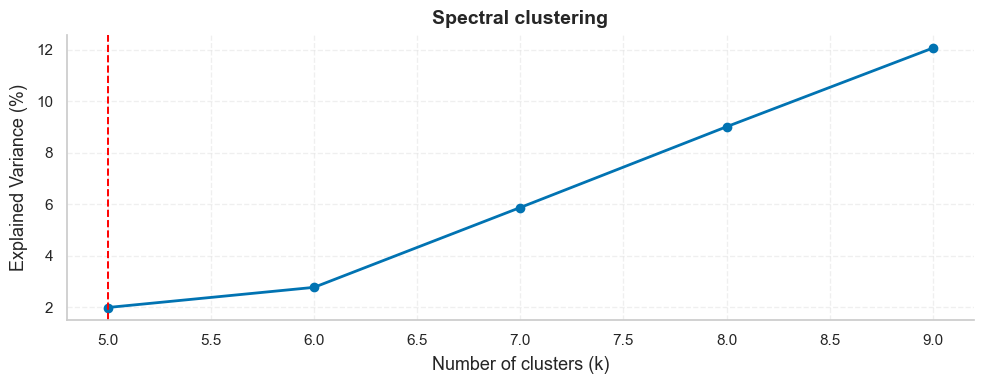

In [33]:
plot_spectral_clustering_elbows([cluster_result], 
                                titles=["Spectral clustering"], 
                                vline_x=5,
                                fn="../output/figures/20250702_store_spectral_clustering_elbow.tiff")

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/retail/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/retail/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


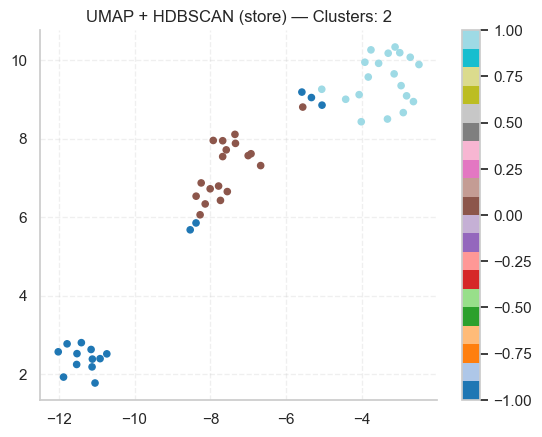

In [34]:


def plot_umap_hdbscan(X, title="UMAP + HDBSCAN", axis_label="row"):
    embedding = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42).fit_transform(X)
    clusterer = HDBSCAN(min_cluster_size=15).fit(embedding)
    
    labels = clusterer.labels_
    plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap="tab20", s=20)
    plt.title(f"{title} ({axis_label}) — Clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")
    plt.colorbar()
    plt.show()

plot_umap_hdbscan(df_weekly.values, axis_label="store")
#plot_umap_hdbscan(df_weekly.values.T, axis_label="item")


In [50]:
P_est, Q_est = estimate_pq_with_umap_hdbscan(df_weekly.values, min_cluster_size=10, n_neighbors=15, min_dist=0.1, random_state=42)

/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [51]:
print(P_est)
print(Q_est)



3
8


In [58]:
gdkm_model = GeneralizedDoubleKMeans(
        n_row_clusters=3,
        n_col_clusters_list=[8]*3,
        max_iter=100,
        tol=1e-4,
        random_state=0,
        norm="l1"
    )
gdkm_model.fit(df_weekly.values)

Iteration 0: Loss=1.89e+04, max X=5.314614295959473, max cp=0.18997538469755837
Iteration 1: Loss=1.30e+04, max X=5.314614295959473, max cp=0.9693086595913869
Iteration 2: Loss=1.17e+04, max X=5.314614295959473, max cp=1.3926062923948601
Iteration 3: Loss=1.13e+04, max X=5.314614295959473, max cp=1.5972911476788385
Iteration 4: Loss=1.10e+04, max X=5.314614295959473, max cp=1.7456304504269844
Iteration 5: Loss=1.08e+04, max X=5.314614295959473, max cp=1.8690222924918058
Iteration 6: Loss=1.07e+04, max X=5.314614295959473, max cp=1.9230328835687436
Iteration 7: Loss=1.07e+04, max X=5.314614295959473, max cp=1.9805320391281944
Iteration 8: Loss=1.06e+04, max X=5.314614295959473, max cp=2.0639770507131914
Iteration 9: Loss=1.06e+04, max X=5.314614295959473, max cp=2.1580144338756457
Iteration 10: Loss=1.05e+04, max X=5.314614295959473, max cp=2.3182833146601065
Iteration 11: Loss=1.05e+04, max X=5.314614295959473, max cp=2.3846334032236767
Iteration 12: Loss=1.04e+04, max X=5.314614295959

GeneralizedDoubleKMeans(n_col_clusters_list=[8, 8, 8], norm='l1',
                        random_state=0)

In [59]:
for p, Vp in enumerate(gdkm_model.V_list_):
    counts = Vp.sum(axis=1)
    l = len(counts)
    print(f"Store cluster {p} - item clusters: {l}")
#gdkm_model.V_list_

Store cluster 0 - item clusters: 500
Store cluster 1 - item clusters: 500
Store cluster 2 - item clusters: 500


/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/plot_util.py:996: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


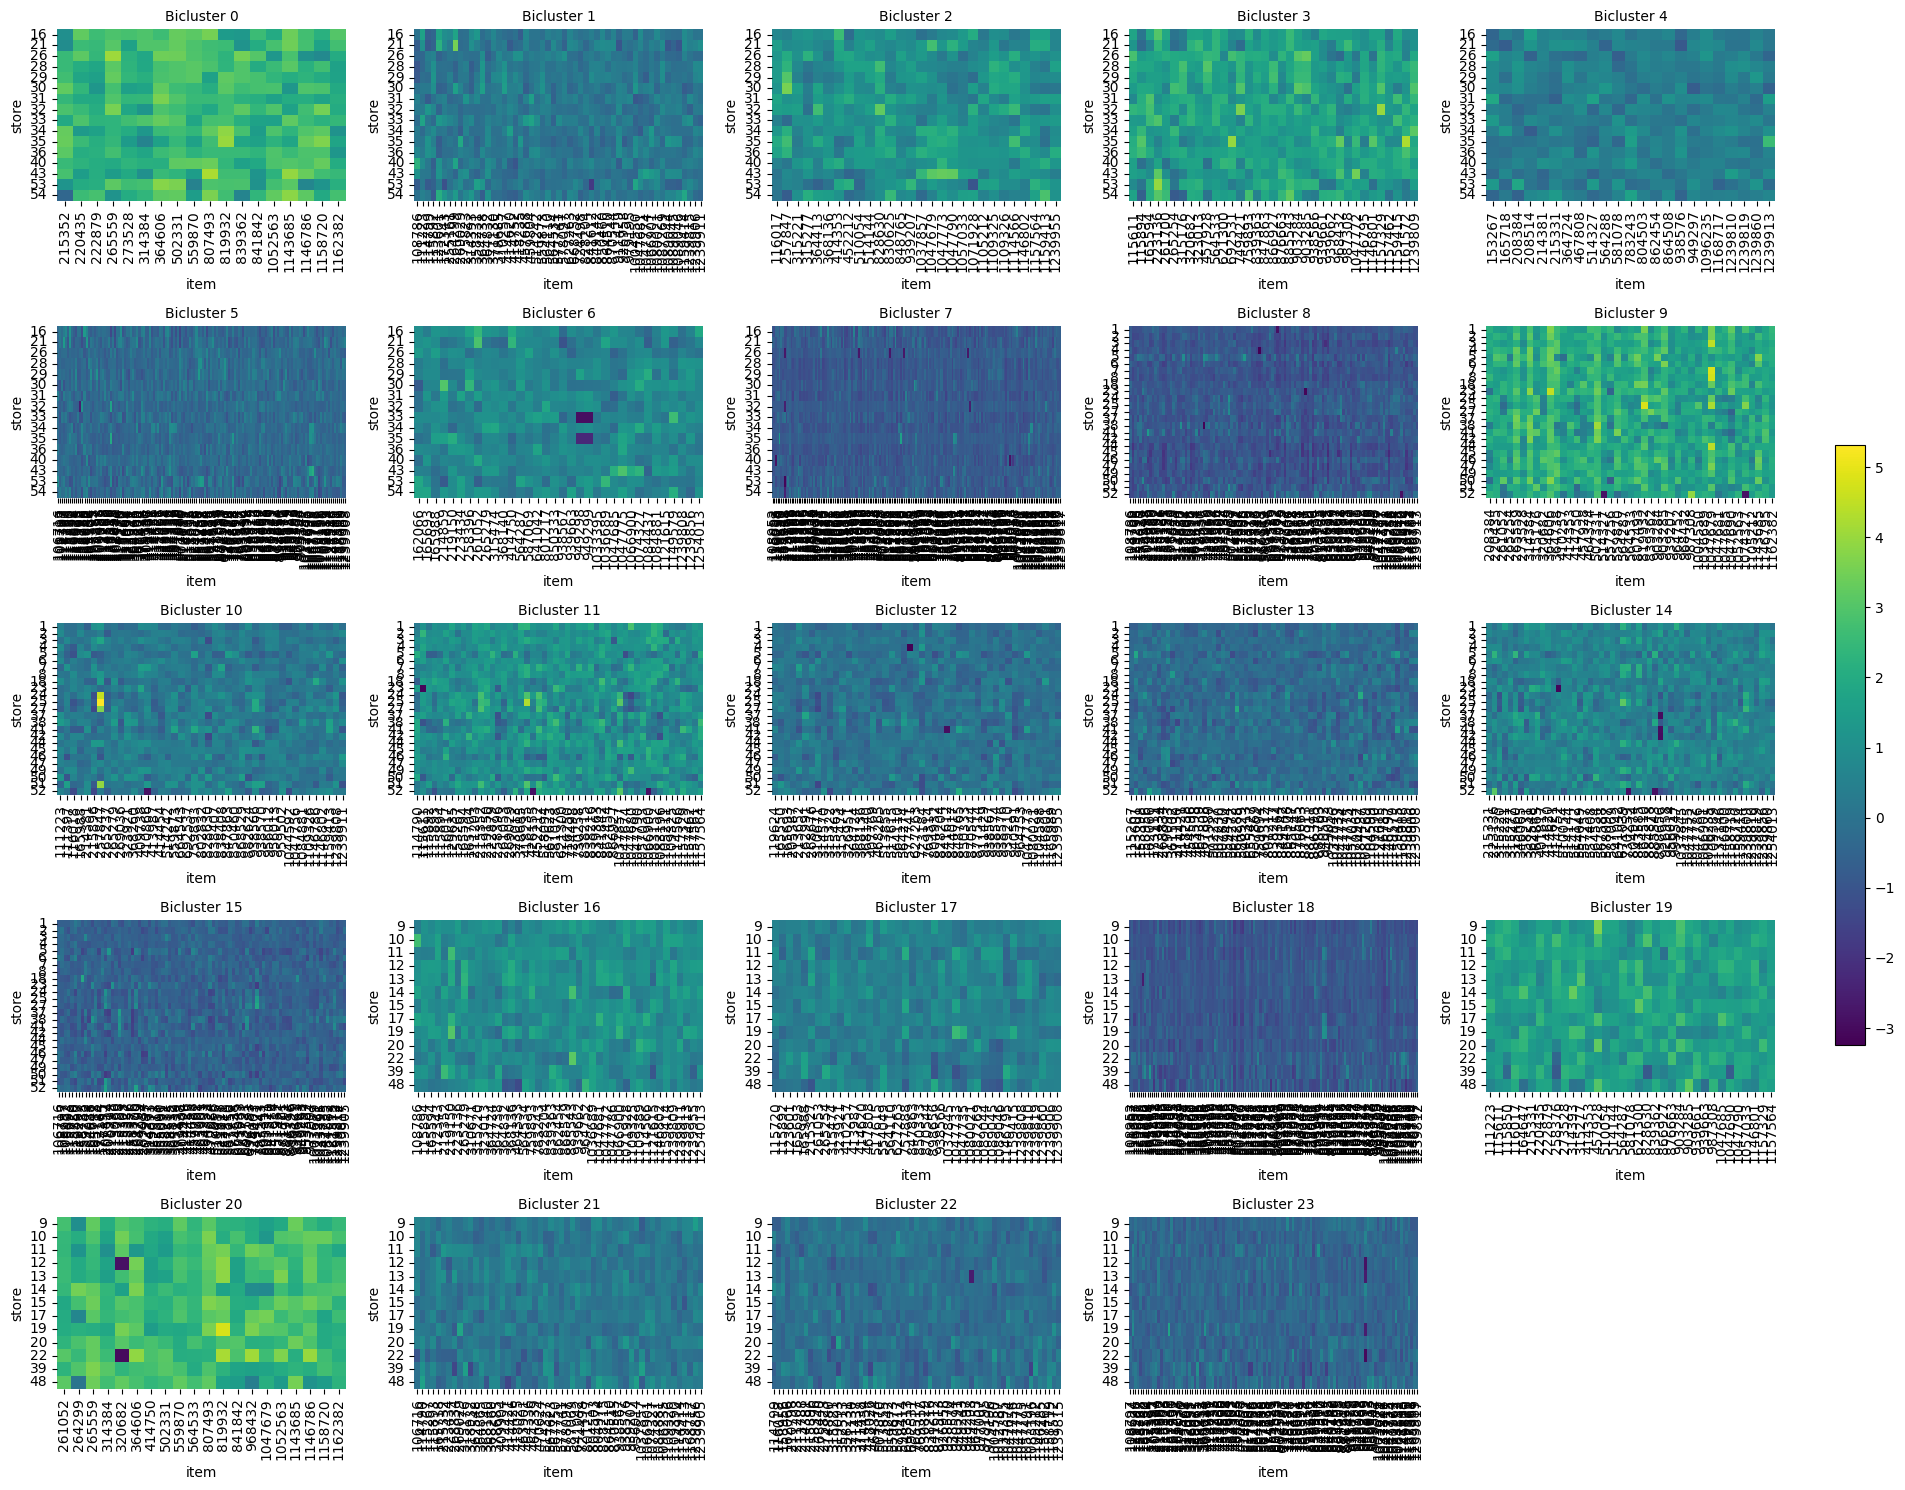

In [63]:
rows, cols = gdkm_model.get_biclusters()
fn = "../output/figures/20250629_weekly_median_54_500_store_item_unit_sales_gdkm_l1_with_clusters.tiff"
plot_bicluster_grid(df_weekly, rows, cols, show_labels=True, single_cbar=True, fn=fn)

/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/plot_util.py:996: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


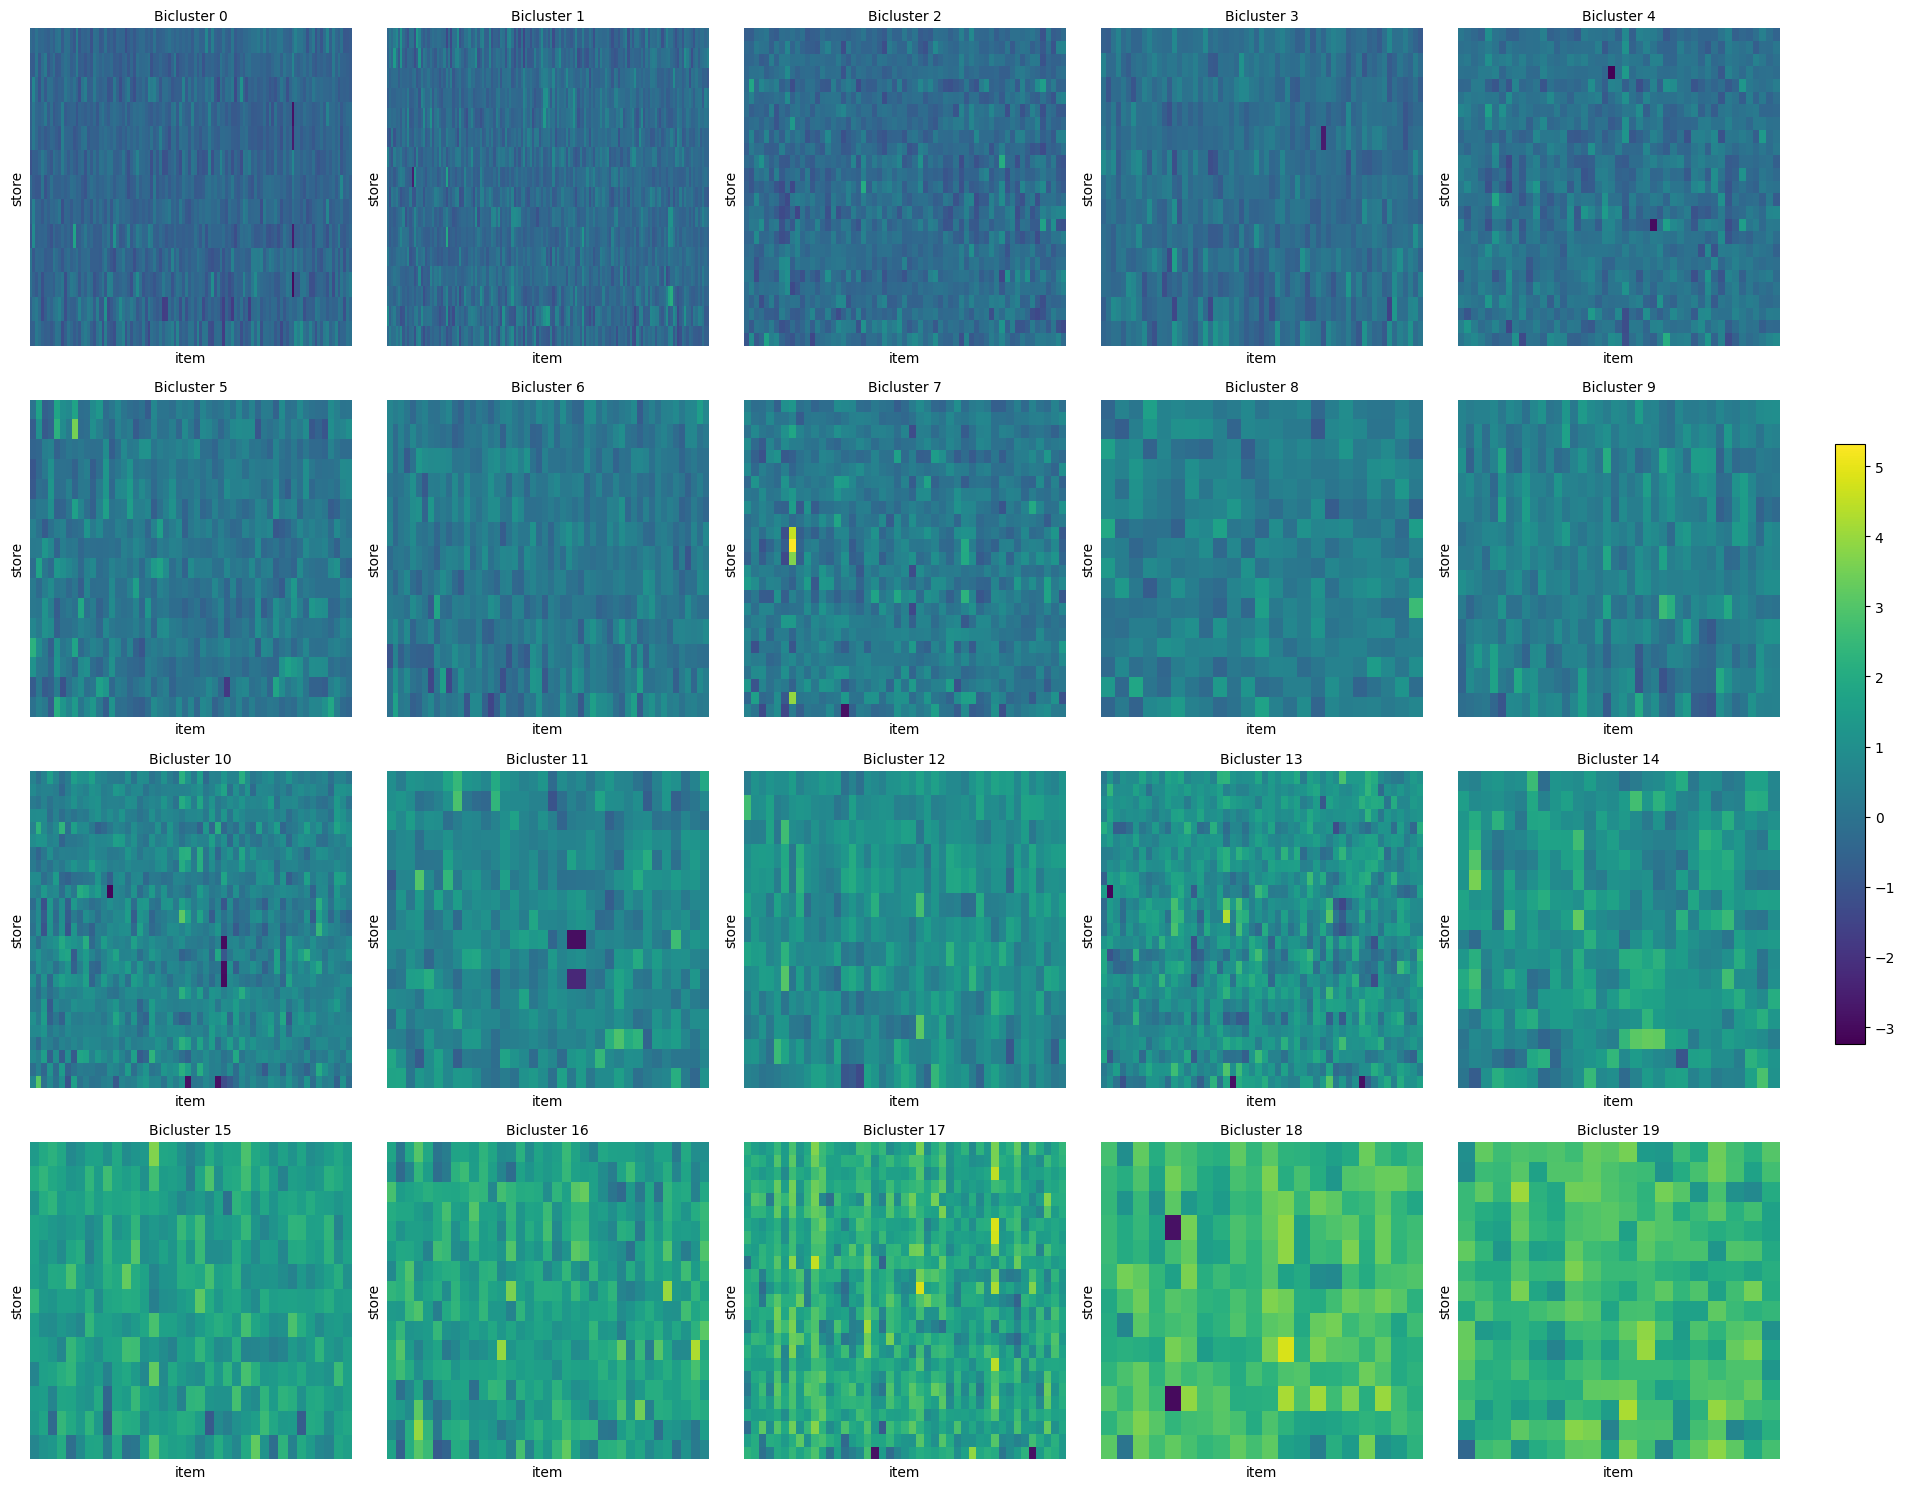

In [64]:
# Example: Select top 20 biclusters with highest median intensity
rows, cols = gdkm_model.get_biclusters()
bicluster_medians = [
    df_weekly.loc[r, c].median().median()
    for r, c in zip(rows, cols)
]
top_k = np.argsort(bicluster_medians)[-20:]
row_masks_filtered = rows[top_k]
col_masks_filtered = cols[top_k]
fn = "../output/figures/20250629_weekly_top_20_bicluster_median_54_500_store_item_unit_sales_gdkm_l1_with_clusters.tiff"
plot_bicluster_grid(df_weekly, row_masks_filtered, col_masks_filtered, fn=fn)


In [68]:
cluster_df = gdkm_model.get_cluster_assignments(df_weekly)

In [69]:
cluster_df.to_csv("../output/data/20250629_cluster_df.csv", index=False)

In [36]:
store_item_matrix = df.pivot_table(
    index='store',
    columns='item',
    values='unit_sales',
    aggfunc='mean'  # or 'sum', 'max', etc.
)

store_item_matrix = store_item_matrix.fillna(0)
store_item_matrix


item,114790,305229,314384,364606,502331,567623,581078,582864,584028,1047679
store,,,,,,,,,,
3,27.108124,63.950417,101.274788,107.482674,75.588409,31.792114,17.258219,71.035988,64.032539,444.109314
8,11.149940,27.755703,55.296295,63.240742,45.220428,18.643156,14.933692,27.518524,47.129799,227.244324
44,34.733692,55.383373,104.248505,112.069977,85.783752,50.167862,50.083782,59.410400,78.856087,495.701324
45,41.463562,49.682796,139.155914,132.439072,71.828552,53.934887,33.095867,84.386185,191.282730,129.111176
46,39.949131,33.993408,106.913879,109.719070,75.030464,39.524551,35.617825,129.463562,207.365662,123.478493
47,36.595810,62.344685,115.031067,119.578598,86.900833,44.974895,34.894863,72.931549,122.660606,191.991638
48,37.768082,33.579201,82.525406,85.804062,77.191757,27.651731,30.169754,83.582352,273.251373,63.222820
49,22.993425,39.906212,70.789726,76.007172,62.272400,31.137396,12.925284,55.208302,73.311699,103.075356
50,32.529942,24.746714,88.255241,105.722221,62.578255,22.468544,49.909691,78.884956,159.557663,23.912029


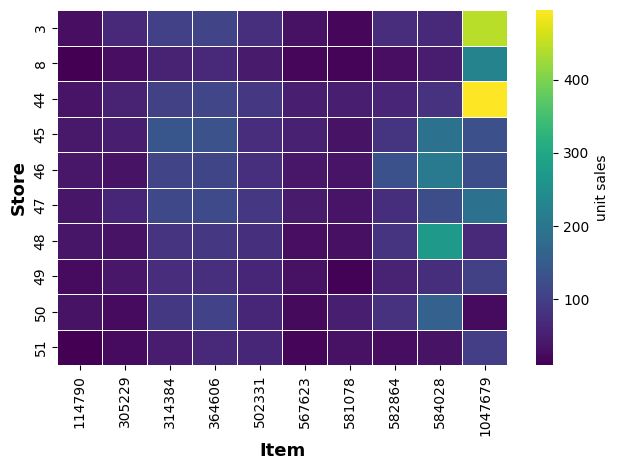

In [37]:
ax = sns.heatmap(
    store_item_matrix,
    cmap="viridis",
    linewidths=.5,          # thin separator lines
    linecolor="white",
cbar_kws={"label": "unit sales"}
)

#ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Item", fontsize=13, fontweight="bold")
ax.set_ylabel("Store",       fontsize=13, fontweight="bold")

plt.tight_layout()

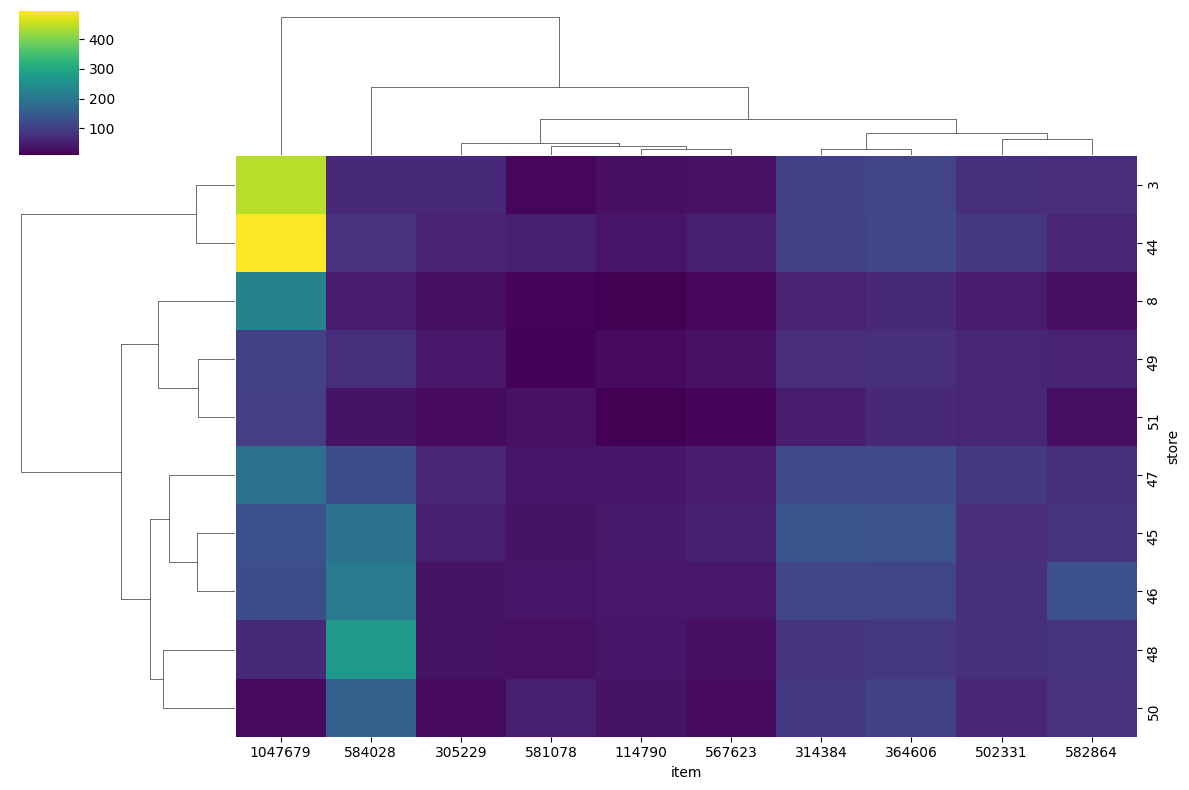

In [38]:
sns.clustermap(store_item_matrix, cmap='viridis', figsize=(12, 8))


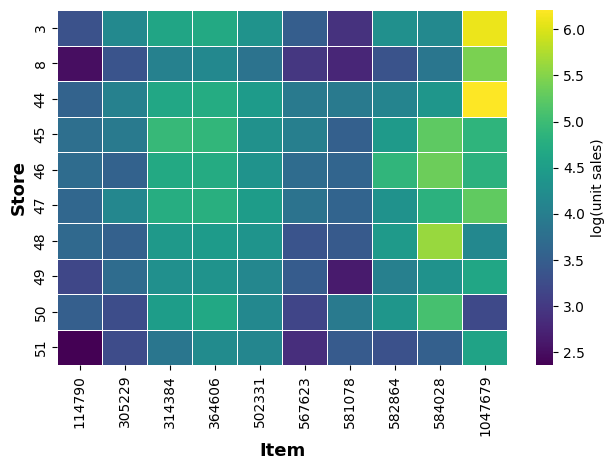

In [39]:
matrix_log = np.log1p(store_item_matrix)
ax = sns.heatmap(
    matrix_log,
    cmap="viridis",
    linewidths=.5,          # thin separator lines
    linecolor="white",
cbar_kws={"label": "log(unit sales)"}
)

#ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Item", fontsize=13, fontweight="bold")
ax.set_ylabel("Store",  fontsize=13, fontweight="bold")

plt.tight_layout()


<Axes: xlabel='item', ylabel='store'>

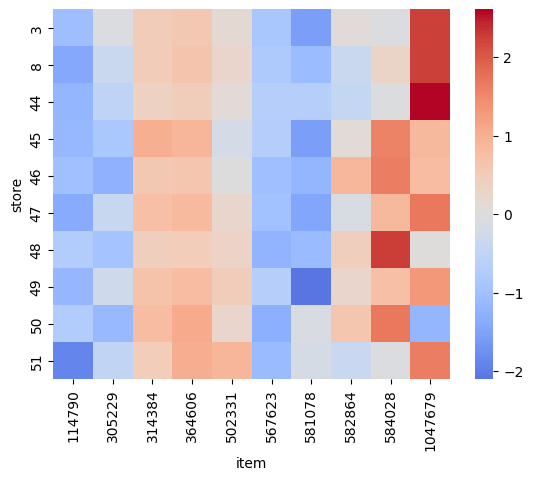

In [40]:
from scipy.stats import zscore

# Normalize each store’s sales profile across items
matrix_norm = matrix_log.apply(zscore, axis=1)  # axis=1 → row-wise
sns.heatmap(matrix_norm, cmap='coolwarm', center=0)

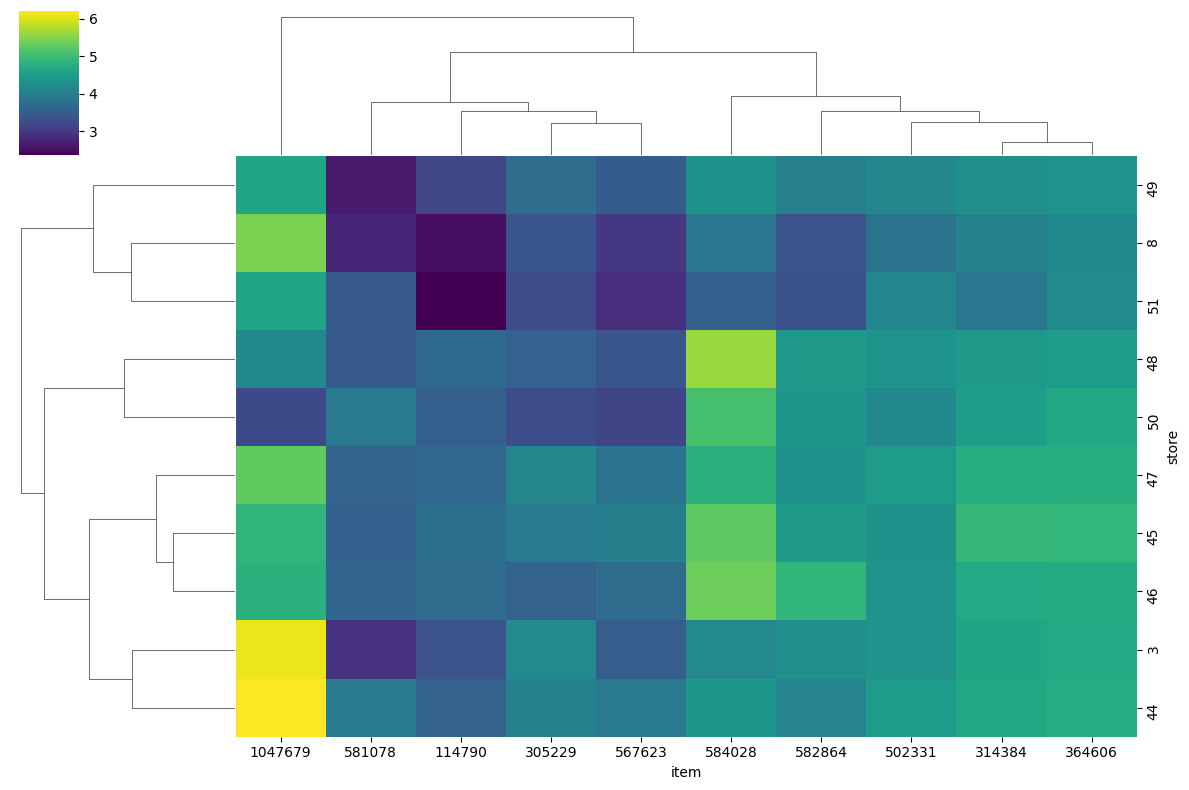

In [41]:
sns.clustermap(matrix_log, cmap='viridis', figsize=(12, 8))


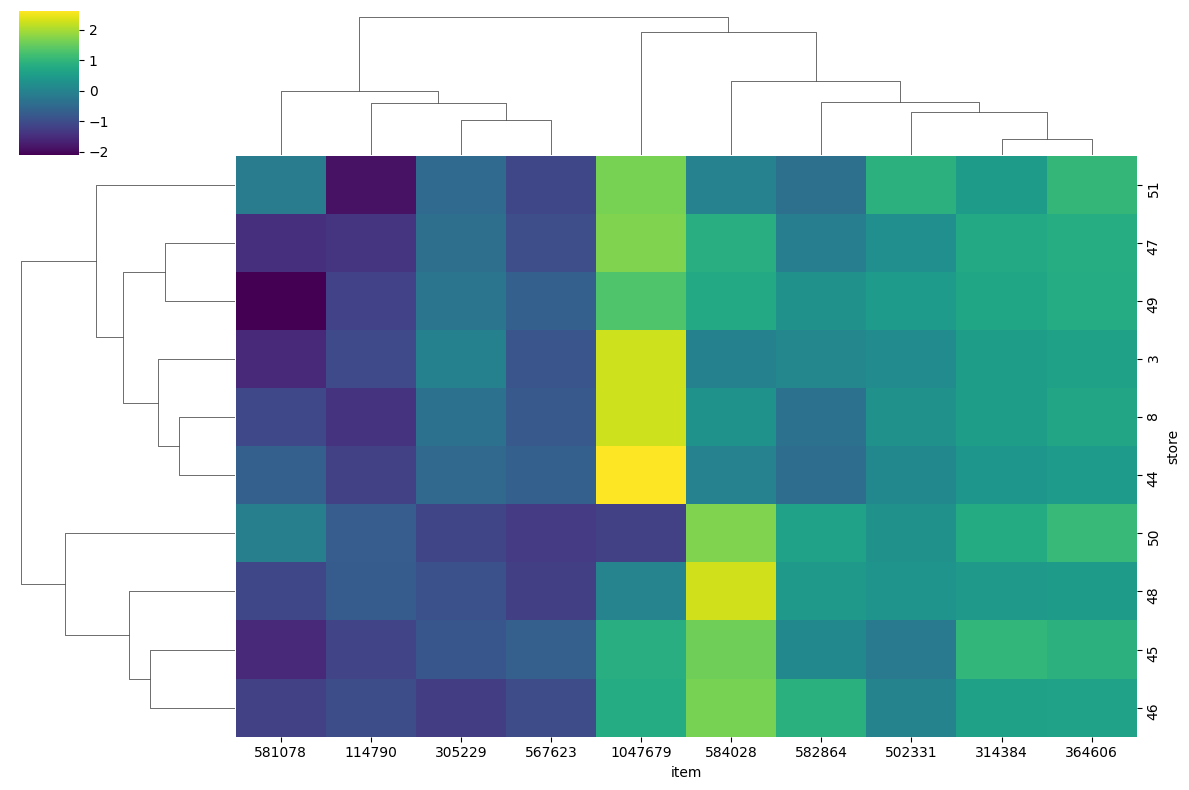

In [42]:
sns.clustermap(matrix_norm, cmap='viridis', figsize=(12, 8))


In [43]:
model = SpectralBiclustering(n_clusters=5, method='log', random_state=0)
model.fit(store_item_matrix)

SpectralBiclustering(method='log', n_clusters=5, random_state=0)

In [44]:
# Get reordered indices
row_order = np.argsort(model.row_labels_)
col_order = np.argsort(model.column_labels_)

# Reorder the matrix
matrix_ordered = store_item_matrix.iloc[row_order, col_order]

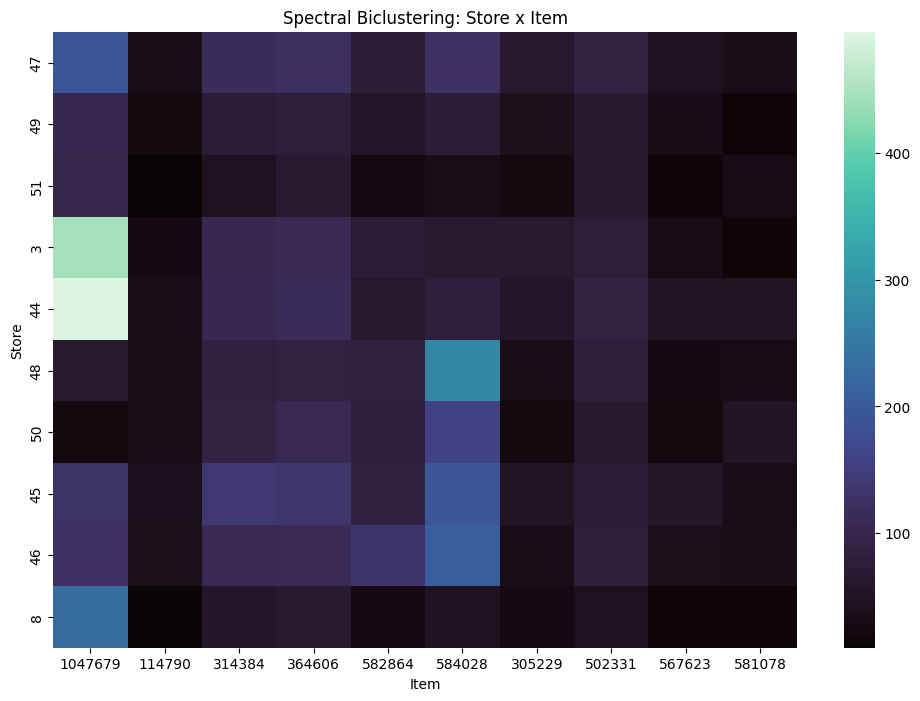

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(matrix_ordered, cmap='mako')
plt.title("Spectral Biclustering: Store x Item")
plt.xlabel("Item")
plt.ylabel("Store")
plt.show()


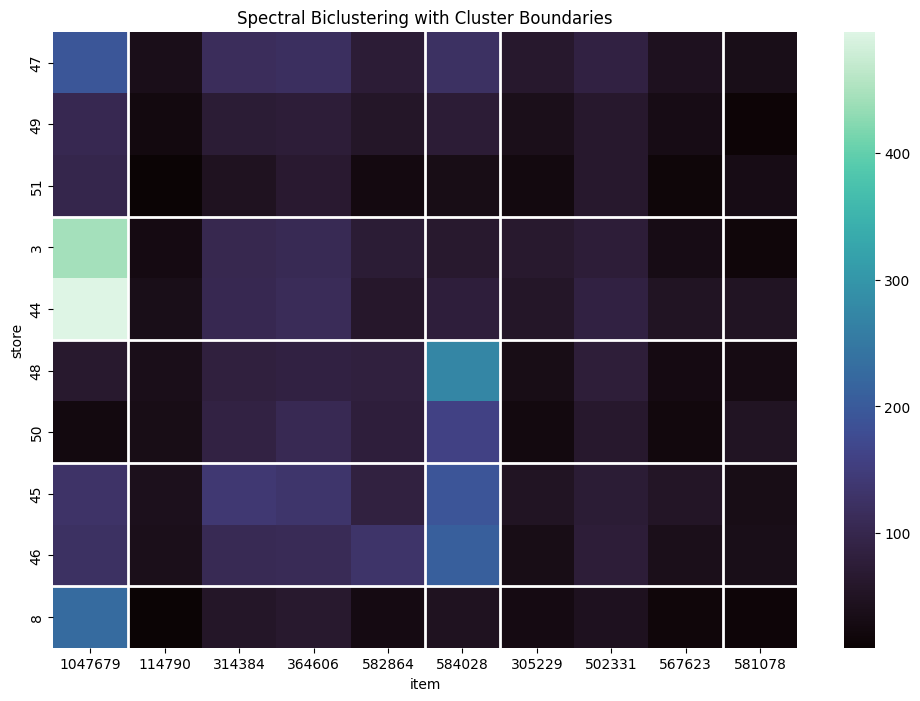

In [46]:
import numpy as np

# Number of row/col clusters
n_row_clusters = len(set(model.row_labels_))
n_col_clusters = len(set(model.column_labels_))

# Row/Col boundaries
row_cuts = [np.where(np.diff(np.sort(model.row_labels_)) != 0)[0] + 1]
col_cuts = [np.where(np.diff(np.sort(model.column_labels_)) != 0)[0] + 1]

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(matrix_ordered, cmap='mako', cbar=True)

for r in row_cuts[0]:
    plt.axhline(r, color='white', linewidth=2)
for c in col_cuts[0]:
    plt.axvline(c, color='white', linewidth=2)

plt.title("Spectral Biclustering with Cluster Boundaries")
plt.show()


In [47]:
model = SpectralBiclustering(n_clusters=7, method='log', random_state=0)
model.fit(matrix_norm)

SpectralBiclustering(method='log', n_clusters=7, random_state=0)

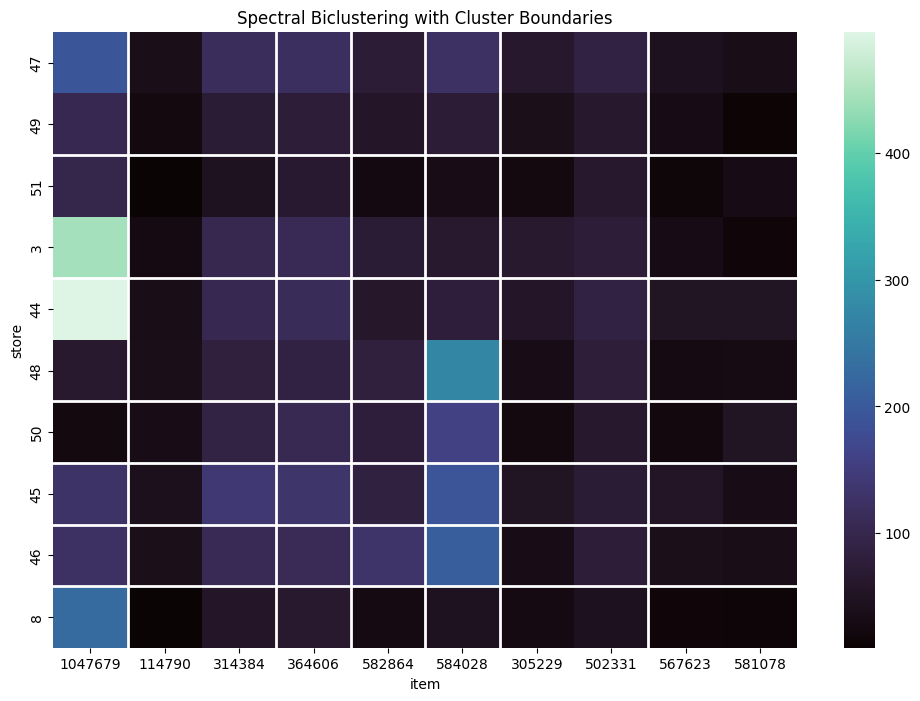

In [48]:
# Number of row/col clusters
n_row_clusters = len(set(model.row_labels_))
n_col_clusters = len(set(model.column_labels_))

# Row/Col boundaries
row_cuts = [np.where(np.diff(np.sort(model.row_labels_)) != 0)[0] + 1]
col_cuts = [np.where(np.diff(np.sort(model.column_labels_)) != 0)[0] + 1]

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(matrix_ordered, cmap='mako', cbar=True)

for r in row_cuts[0]:
    plt.axhline(r, color='white', linewidth=2)
for c in col_cuts[0]:
    plt.axvline(c, color='white', linewidth=2)

plt.title("Spectral Biclustering with Cluster Boundaries")
plt.show()

In [58]:
model = GeneralizedDoubleKMeans(n_row_clusters=5, n_col_clusters_list=[5] * 5, random_state=0)
X_np = np.random.poisson(5, (10, 8))  # Placeholder in case store_item_matrix is unavailable here
model.fit(X_np)

ValueError: All column cluster blocks are empty or malformed.

In [62]:
X_debug = np.random.poisson(5, (10, 25))  # 10 stores, 25 items

U_dbg, V_list_dbg, C_blocks_dbg, loss_dbg = generalized_double_kmeans(
    X_debug,
    P=5,
    Q_list=[5] * 5,  # One Qp per row cluster
    max_iter=100,
    tol=1e-4,
    random_state=0
)

[(Vp.shape, Vp.ndim) for Vp in V_list_dbg]


[((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1)]

In [57]:
model = GeneralizedDoubleKMeans(n_row_clusters=5, n_col_clusters_list=[3] * 3, random_state=0)
model.fit(store_item_matrix.values)

IndexError: list index out of range

In [12]:

# Example: aggregate by dayofweek
store_clust_df = df.groupby(["store", "dayofweek"])["unit_sales"].sum().unstack(fill_value=0)
store_clust_df

KeyError: 'dayofweek'

In [8]:
X, pivot_clean = preprocess_sales_matrix(store_clust_df, log_transform=True, smooth_window=16, zscore_rows=True)

/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/utils.py:421: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df = df.rolling(window=smooth_window, axis=1, min_periods=1).mean()


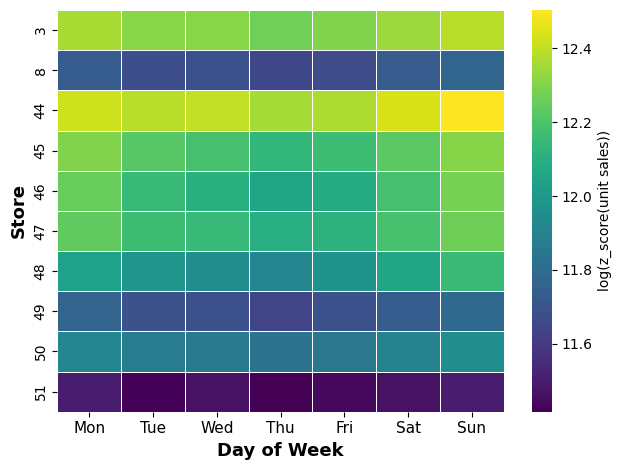

In [9]:

day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
norm = plt.Normalize(vmin=pivot_clean.values.min(),
                     vmax=pivot_clean.values.max())


ax = sns.heatmap(
    pivot_clean,
    cmap="viridis",
    linewidths=.5,          # thin separator lines
    linecolor="white",
cbar_kws={"label": "log(z_score(unit sales))"}
)

ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Day of Week", fontsize=13, fontweight="bold")
ax.set_ylabel("Store",       fontsize=13, fontweight="bold")

plt.tight_layout()
fn = "../output/figures/2025-06-07_heatmap_store_sales_matrix.tiff"
plt.savefig(fn, dpi=300)
plt.show()
plt.close()



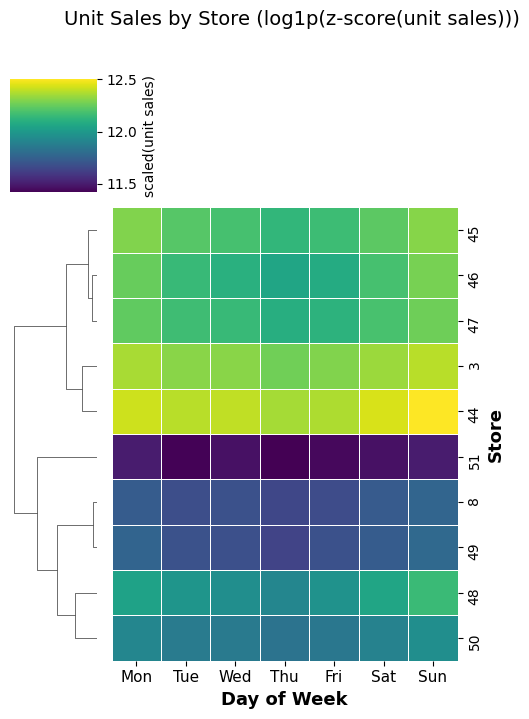

In [19]:
day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# ---------------------------------------------------------------------
# build the clustermap
# ---------------------------------------------------------------------
grid = sns.clustermap(
    pivot_clean,
    cmap="viridis",
    row_cluster=True,
    col_cluster=False,          # keep Mon→Sun order
    linewidths=.4, linecolor="white",
    figsize=(6, 7),
  #      cbar_pos=(0.90, 0.20, 0.03, 0.65),   # [x, y, width, height]
    cbar_kws={
        "label": "scaled(unit sales)",
        "orientation": "vertical",   # just to be explicit
    }
)

# tidy up the heat‑map axis
ax = grid.ax_heatmap
ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Day of Week",  fontsize=13, fontweight="bold")
ax.set_ylabel("Store",        fontsize=13, fontweight="bold")

# overall title (use the figure, not the heat‑map axis)
grid.figure.suptitle(
    "Unit Sales by Store (log1p(z‑score(unit sales)))",
    fontsize=14, y=1.02
)

# ---------------------------------------------------------------------
# FIRST let matplotlib tighten up everything *else* …
# ---------------------------------------------------------------------
#grid.figure.tight_layout(rect=[0, 0, 0.88, 1])     # leave room on the right

# ---------------------------------------------------------------------
# … THEN move / resize the colour‑bar
# ---------------------------------------------------------------------

# optional: put tick labels on the outside
#grid.cax.yaxis.set_label_position('right')
grid.cax.yaxis.tick_right()
grid.figure.tight_layout(rect=[0, 0, 0.88, 1])

# ---------------------------------------------------------------------
# save / show
# ---------------------------------------------------------------------
fn = "../output/figures/2025-06-07_clustered_store_sales_matrix.tiff"
grid.figure.savefig(fn, dpi=300    )
plt.show()
plt.close()


In [25]:
results_spectral_clustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralClustering,
    n_clusters_row_range=range(2, 8),
    cv_folds=3
)
results_spectral_clustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-p

,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,42.022753,0.541314,NaN
1,3,NaN,58.289140,0.225026,NaN
2,4,NaN,79.633059,0.458693,NaN
3,5,NaN,78.637807,0.458693,NaN
4,6,NaN,83.910748,0.445367,NaN


In [21]:
results_spectral_biclustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralBiclustering,
    n_clusters_row_range=range(2, 8),  
    cv_folds=3
)
results_spectral_biclustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,63.539831,0.541314,NaN
1,3,NaN,55.149080,0.392015,NaN
2,4,NaN,67.576050,0.392015,NaN
3,5,NaN,75.310768,0.177420,NaN
4,6,NaN,84.248961,0.458693,NaN


In [28]:
results_spectral_coclustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralCoclustering,
    n_clusters_row_range=range(2, 8),  
    cv_folds=3
)
results_spectral_coclustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,36.404406,0.541314,NaN
1,3,NaN,51.316306,0.541314,NaN
2,4,NaN,52.517374,0.177420,NaN
3,5,NaN,88.013466,0.445367,NaN
4,6,NaN,91.179629,0.445367,NaN


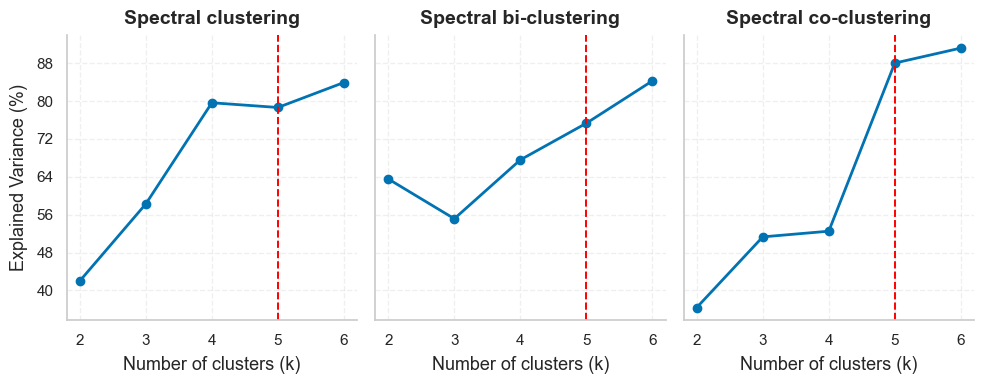

In [35]:
plot_spectral_clustering_elbows([results_spectral_clustering, results_spectral_biclustering, results_spectral_coclustering], 
                                titles=["Spectral clustering", 
                                        "Spectral bi-clustering", 
                                        "Spectral co-clustering"], 
                                vline_x=5,
                                fn="../output/figures/20250610_store_spectral_clustering_elbow.tiff")

In [36]:
store_clusters = generate_store_item_clusters(pivot_clean, n_clusters=5, model_class=SpectralClustering)
store_clusters

,store_item,clusterId
0,3,3
1,8,1
2,44,3
3,45,2
4,46,2
5,47,4
6,48,0
7,49,1
8,50,0
9,51,1


In [52]:
store_clusters.to_excel("../output/data/20250610_store_clusters.xlsx", index=False)


In [39]:
item_clust_df = df.groupby(["item", "dayofweek"])["unit_sales"].sum().unstack(fill_value=0)
item_clust_df

dayofweek,0,1,2,3,4,5,6
item,,,,,,,
114790,65934.00000,58541.000000,61027.000000,49694.000000,59724.00000,92168.000000,104334.000000
305229,100526.00000,87752.000000,96594.000000,77143.000000,94014.00000,113315.000000,126298.000000
314384,208535.00000,178413.000000,187639.000000,148368.000000,181779.00000,286893.000000,331265.000000
364606,233280.00000,206453.000000,218815.000000,177461.000000,195605.00000,278954.000000,326067.000000
502331,174052.00000,139167.000000,140516.000000,118401.000000,136309.00000,200200.000000,269012.000000
567623,80895.00000,65895.000000,66624.000000,52940.000000,61229.00000,100220.000000,135745.000000
581078,70016.00000,64095.000000,71520.000000,58879.000000,71888.00000,88769.000000,92420.000000
582864,148046.03125,131828.734375,130798.570312,123210.703125,262692.65625,173113.109375,183678.265625
584028,291425.68750,257868.406250,257720.062500,234997.234375,334694.56250,342394.843750,372661.968750


In [40]:
X, pivot_clean = preprocess_sales_matrix(item_clust_df, log_transform=True, smooth_window=16, zscore_rows=True)

/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/utils.py:421: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df = df.rolling(window=smooth_window, axis=1, min_periods=1).mean()


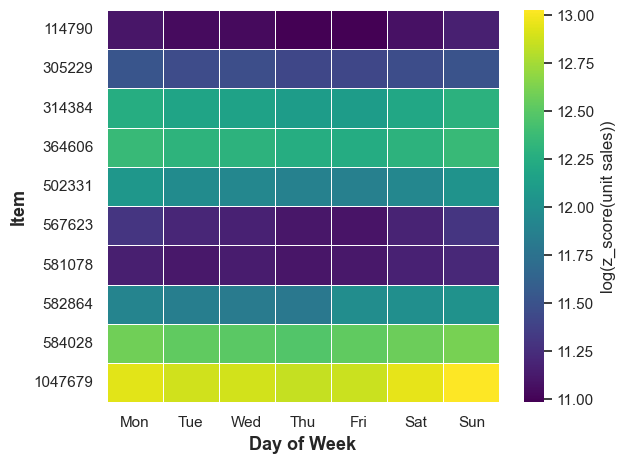

In [41]:
day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
norm = plt.Normalize(vmin=pivot_clean.values.min(),
                     vmax=pivot_clean.values.max())


ax = sns.heatmap(
    pivot_clean,
    cmap="viridis",
    linewidths=.5,          # thin separator lines
    linecolor="white",
cbar_kws={"label": "log(z_score(unit sales))"}
)

ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Day of Week", fontsize=13, fontweight="bold")
ax.set_ylabel("Item",       fontsize=13, fontweight="bold")

plt.tight_layout()
fn = "../output/figures/20250610_heatmap_item_sales_matrix.tiff"
plt.savefig(fn, dpi=300)
plt.show()
plt.close()

/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_17412/3335997768.py:34: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  grid.figure.tight_layout(rect=[0, 0, 0.88, 1])
/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_17412/3335997768.py:40: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  grid.figure.savefig(fn, dpi=300    )
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


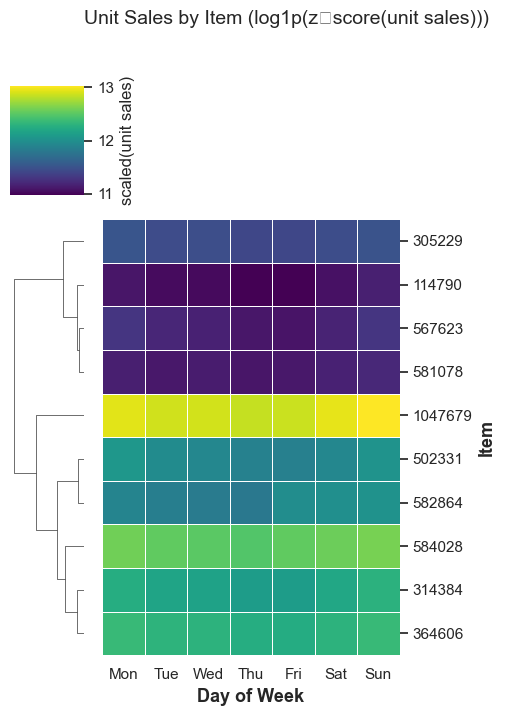

In [42]:
day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# ---------------------------------------------------------------------
# build the clustermap
# ---------------------------------------------------------------------
grid = sns.clustermap(
    pivot_clean,
    cmap="viridis",
    row_cluster=True,
    col_cluster=False,          # keep Mon→Sun order
    linewidths=.4, linecolor="white",
    figsize=(6, 7),
  #      cbar_pos=(0.90, 0.20, 0.03, 0.65),   # [x, y, width, height]
    cbar_kws={
        "label": "scaled(unit sales)",
        "orientation": "vertical",   # just to be explicit
    }
)

# tidy up the heat‑map axis
ax = grid.ax_heatmap
ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Day of Week",  fontsize=13, fontweight="bold")
ax.set_ylabel("Item",        fontsize=13, fontweight="bold")

# overall title (use the figure, not the heat‑map axis)
grid.figure.suptitle(
    "Unit Sales by Item (log1p(z‑score(unit sales)))",
    fontsize=14, y=1.02
)


grid.cax.yaxis.tick_right()
grid.figure.tight_layout(rect=[0, 0, 0.88, 1])

# ---------------------------------------------------------------------
# save / show
# ---------------------------------------------------------------------
fn = "../output/figures/20250610_clustered_item_sales_matrix.tiff"
grid.figure.savefig(fn, dpi=300    )
plt.show()
plt.close()


In [44]:
results_spectral_clustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralClustering,
    n_clusters_row_range=range(2, 8),
    cv_folds=3
)
results_spectral_clustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4


/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-p

Evaluating n_row=5
Evaluating n_row=6


/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:372: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  _, diffusion_map = eigsh(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning:

,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,59.052952,0.502932,NaN
1,3,NaN,86.294428,0.297913,NaN
2,4,NaN,88.017222,0.482839,NaN
3,5,NaN,90.963996,0.514127,NaN
4,6,NaN,91.246928,0.514127,NaN


In [45]:
results_spectral_biclustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralBiclustering,
    n_clusters_row_range=range(2, 7),  
    cv_folds=3
)
results_spectral_biclustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,29.414937,0.502932,NaN
1,3,NaN,50.118215,0.585602,NaN
2,4,NaN,82.861211,0.585602,NaN
3,5,NaN,87.247744,0.236738,NaN
4,6,NaN,87.247744,0.236738,NaN


In [46]:
results_spectral_coclustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralCoclustering,
    n_clusters_row_range=range(2, 8),  
    cv_folds=3
)
results_spectral_coclustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,13.132559,0.248948,NaN
1,3,NaN,29.572957,0.502932,NaN
2,4,NaN,31.210978,0.502932,NaN
3,5,NaN,79.531610,0.514127,NaN
4,6,NaN,93.000911,0.585602,NaN


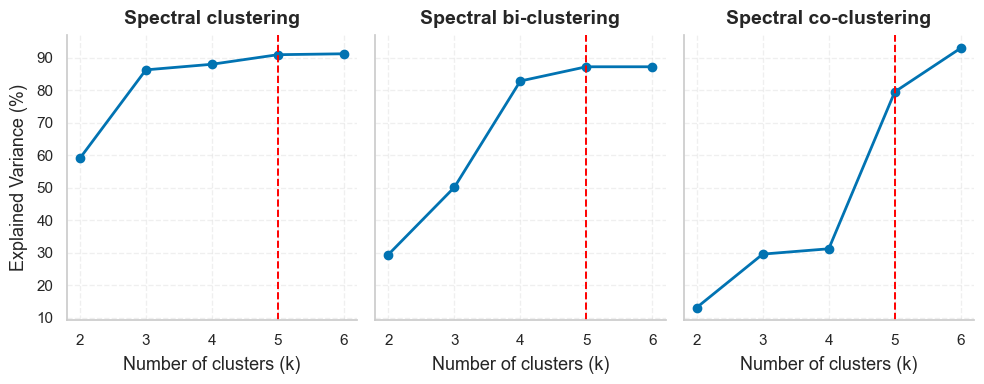

In [48]:
plot_spectral_clustering_elbows([results_spectral_clustering, results_spectral_biclustering, results_spectral_coclustering], 
                                titles=["Spectral clustering", 
                                        "Spectral bi-clustering", 
                                        "Spectral co-clustering"], 
                                vline_x=5,
                                fn="../output/figures/20250610_item_spectral_clustering_elbow.tiff")

In [49]:
item_clusters = generate_store_item_clusters(pivot_clean, n_clusters=4, model_class=SpectralClustering)
item_clusters

,store_item,clusterId
0,114790,1
1,305229,3
2,314384,2
3,364606,2
4,502331,3
5,567623,1
6,581078,1
7,582864,3
8,584028,2
9,1047679,0


In [50]:
item_clusters.to_excel("../output/data/20250610_item_clusters.xlsx", index=False)

In [ ]:
results_df = compute_gdkm_cv_scores(
    X,
    P_range=range(20, 30),   # Try 2 to 7 row clusters
    Q_range=range(20, 30),   # Try 2 to 7 column clusters
    cv_folds=3             # 3-fold CV
)

In [23]:
# With BIC-like penalty (favors simpler models)
best_pq, best_score = suggest_optimal_pq(results_df, criterion='bic', penalty_lambda=0.5)
print(f"Best (P, Q) by penalized loss: {best_pq} → score = {best_score:.3f}")

Best (P, Q) by penalized loss: (2, 4) → score = 210.768


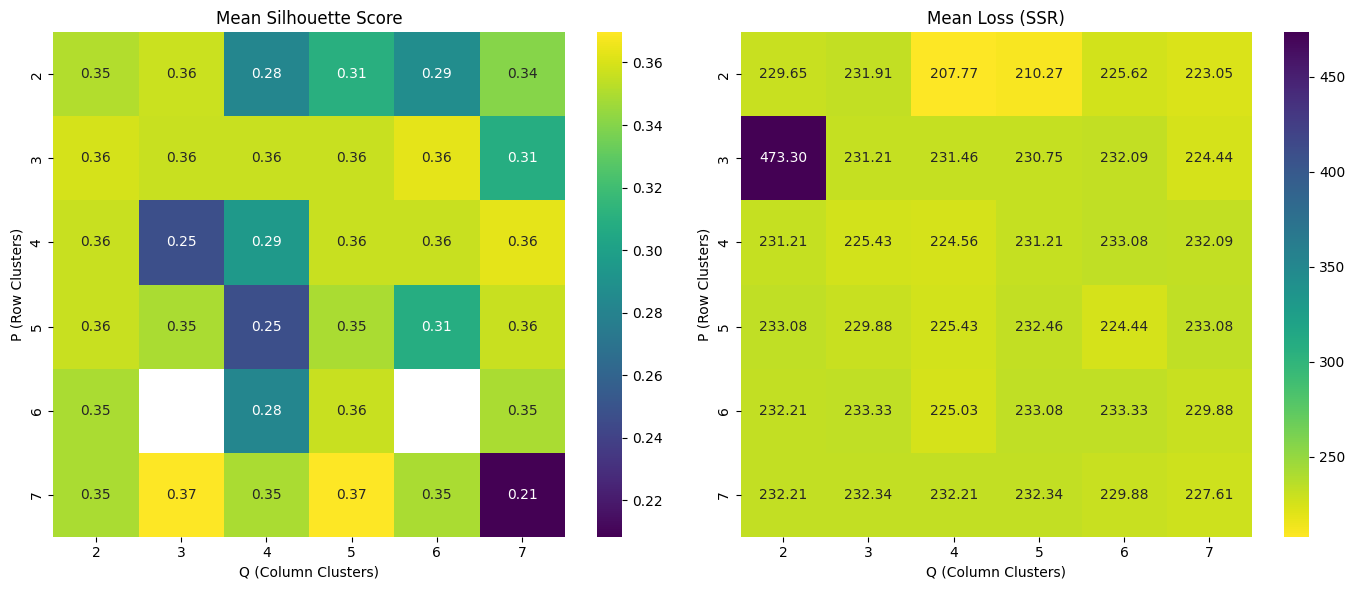

In [24]:
visualize_gdkm_cv_scores(results_df)

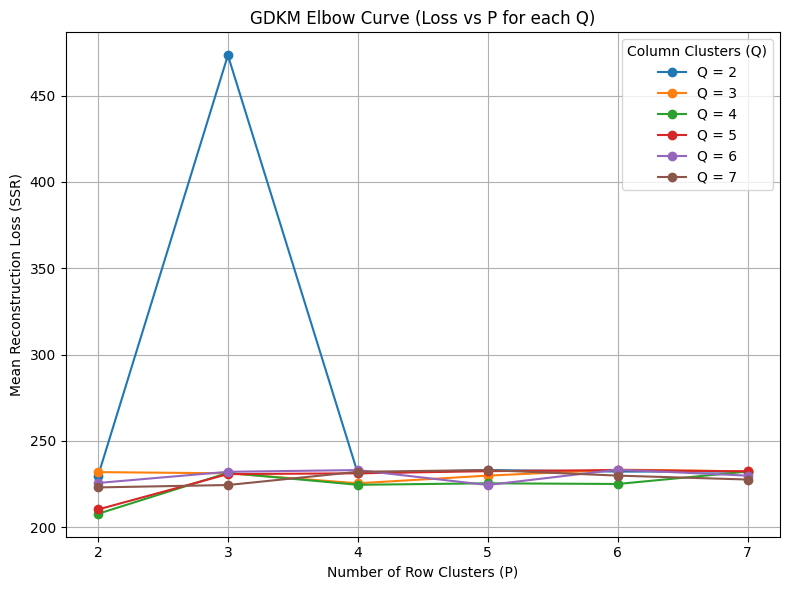

In [25]:
plot_gdkm_elbow_curve(results_df)

In [ ]:

U, V_list, C_blocks, _ = generalized_double_kmeans(
    X, P=4, Q_list=[5]*4, random_state=42
)

visualize_clustered_matrix(X, U, V_list, title="Sales Time-Series Clustering (Preprocessed)")
